In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
TRAIN_DIR = "/mnt/c/Users/ASUS/OneDrive - American International University-Bangladesh/AIUB PDF/AIUB PDF/Semester 10(Fall)/MID/CVPR_Project/CVPR/MID/animal_dataset"  # path to your training data

IMG_SIZE  = (32, 32)         

K_VALUES = [1, 3, 5, 7, 9, 11, 13]
N_FOLDS = 5
RANDOM_STATE = 42


In [ ]:
def load_images_from_folder(root_dir, img_size=(32, 32)):
    
    X = []
    y = []
    classes = [d for d in sorted(os.listdir(root_dir)) 
               if os.path.isdir(os.path.join(root_dir, d))]
    label_map = {cls_name: idx for idx, cls_name in enumerate(classes)}

    for cls_name in classes:
        cls_folder = os.path.join(root_dir, cls_name)
        for file_name in os.listdir(cls_folder):
            if not file_name.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue
            file_path = os.path.join(cls_folder, file_name)
            try:
                img = Image.open(file_path).convert("L")  # grayscale
                img = img.resize(img_size)              
                img_array = np.array(img, dtype=np.float32) 
                X.append(img_array)
                y.append(label_map[cls_name])
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    X = np.array(X)  # (N, 32, 32)
    y = np.array(y)  # (N,)
    return X, y, classes

print("Loading training data...")
X_train_imgs, y_train, class_names = load_images_from_folder(TRAIN_DIR, IMG_SIZE)
print("Training data shape:", X_train_imgs.shape)
print("Training labels shape:", y_train.shape)
print("Classes:", class_names)

Loading training data...
Training data shape: (300, 32, 32)
Training labels shape: (300,)
Classes: ['cat', 'dog', 'panda']


In [ ]:

X_train = X_train_imgs.reshape(len(X_train_imgs), -1)
print("Flattened training data shape:", X_train.shape)

(300, 1024)
Flattened training data shape: (300, 1024)


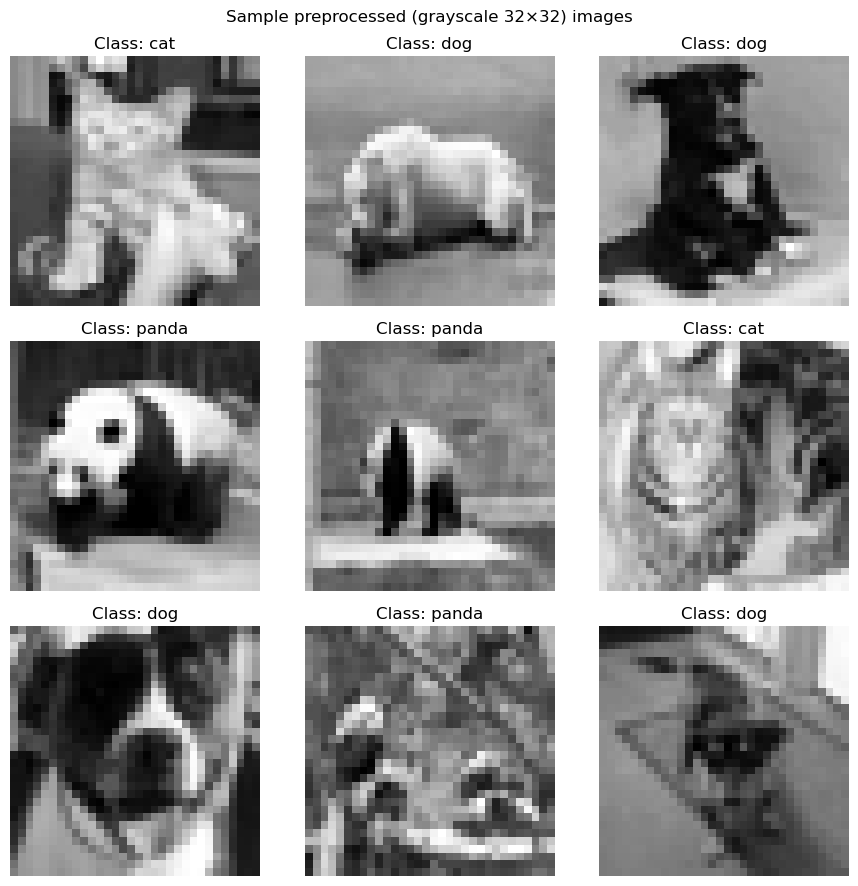

In [ ]:
def show_sample_images(X_imgs, y, class_names, n_samples=9):
    indices = np.random.choice(len(X_imgs), size=n_samples, replace=False)
    cols = 3
    rows = int(np.ceil(n_samples / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_imgs[idx], cmap="gray")
        plt.title(f"Class: {class_names[y[idx]]}")
        plt.axis("off")
    plt.suptitle("Sample preprocessed (grayscale 32*32) images")
    plt.tight_layout()
    plt.show()

show_sample_images(X_train_imgs, y_train, class_names, n_samples=9)


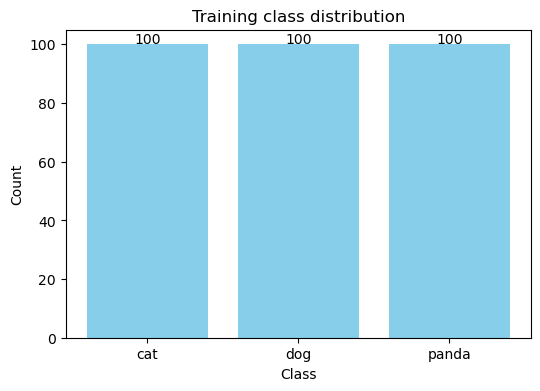

In [271]:
def plot_class_distribution(y, class_names):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar([class_names[u] for u in unique], counts, color="skyblue")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Training class distribution")
    for i, c in enumerate(counts):
        plt.text(i, c + 0.5, str(c), ha="center")
    plt.show()

plot_class_distribution(y_train, class_names)


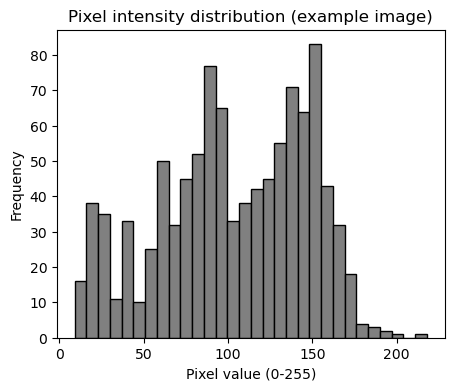

In [272]:
def plot_pixel_histogram(img_array):
   
    plt.figure(figsize=(5, 4))
    plt.hist(img_array.flatten(), bins=30, color="gray", edgecolor="black")
    plt.title("Pixel intensity distribution (example image)")
    plt.xlabel("Pixel value (0-255)")
    plt.ylabel("Frequency")
    plt.show()

example_idx = random.randint(0, len(X_train_imgs) - 1)
plot_pixel_histogram(X_train_imgs[example_idx])

In [273]:
class SimpleKNN:
    def __init__(self, n_neighbors=5, metric="euclidean"):
        assert metric in ("euclidean", "manhattan")
        self.k = n_neighbors
        self.metric = metric
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        return self

    def _compute_distances(self, X):
        X = np.asarray(X)
        if self.metric == "euclidean":
            X_sq = np.sum(X**2, axis=1)[:, None]
            train_sq = np.sum(self.X**2, axis=1)[None, :]
            cross = X @ self.X.T
            dists = np.sqrt(np.clip(X_sq + train_sq - 2 * cross, a_min=0, a_max=None))
        else:  # manhattan
            dists = np.sum(np.abs(X[:, None, :] - self.X[None, :, :]), axis=2)
        return dists

    def predict(self, X):
        X = np.asarray(X)
        dists = self._compute_distances(X)
        nn_idx = np.argpartition(dists, self.k, axis=1)[:, : self.k]
        nn_labels = self.y[nn_idx]
        preds = []
        for row in nn_labels:
            vals, counts = np.unique(row, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)


In [274]:
print("Loading training data...")
X_train_imgs, y_train, class_names = load_images_from_folder(TRAIN_DIR, IMG_SIZE)
print("Training data shape:", X_train_imgs.shape)
print("Training labels shape:", y_train.shape)
print("Classes:", class_names)

# Flatten images
X_flat = X_train_imgs.reshape(len(X_train_imgs), -1)
print("Flattened training data shape:", X_flat.shape)



Loading training data...
Training data shape: (300, 32, 32)
Training labels shape: (300,)
Classes: ['cat', 'dog', 'panda']
Flattened training data shape: (300, 1024)


In [275]:
X_flat_scaled = X_flat.astype('float32') / 255.0

In [276]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

mean_accuracies_l2 = []
mean_accuracies_l1 = []

print("\nPerforming 5-fold cross-validation...\n")
for k in K_VALUES:
    fold_accuracies_l2 = []
    fold_accuracies_l1 = []

    for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(X_flat_scaled, y_train), start=1):
        X_tr, X_val = X_flat_scaled[tr_idx], X_flat_scaled[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        # L2
        knn_l2 = SimpleKNN(n_neighbors=k, metric="euclidean").fit(X_tr, y_tr)
        acc_l2 = accuracy_score(y_val, knn_l2.predict(X_val))
        fold_accuracies_l2.append(acc_l2)

        # L1
        knn_l1 = SimpleKNN(n_neighbors=k, metric="manhattan").fit(X_tr, y_tr)
        acc_l1 = accuracy_score(y_val, knn_l1.predict(X_val))
        fold_accuracies_l1.append(acc_l1)

        print(f"K={k}, Fold={fold_idx}: L2 acc={acc_l2:.4f}, L1 acc={acc_l1:.4f}")

    mean_acc_l2 = np.mean(fold_accuracies_l2)
    mean_acc_l1 = np.mean(fold_accuracies_l1)
    mean_accuracies_l2.append(mean_acc_l2)
    mean_accuracies_l1.append(mean_acc_l1)
    print(f"--> K={k}: L2 mean acc={mean_acc_l2:.4f}, L1 mean acc={mean_acc_l1:.4f}\n")



Performing 5-fold cross-validation...

K=1, Fold=1: L2 acc=0.4000, L1 acc=0.3833
K=1, Fold=2: L2 acc=0.4167, L1 acc=0.4000
K=1, Fold=3: L2 acc=0.3000, L1 acc=0.3167
K=1, Fold=4: L2 acc=0.3333, L1 acc=0.3667
K=1, Fold=5: L2 acc=0.3667, L1 acc=0.4000
--> K=1: L2 mean acc=0.3633, L1 mean acc=0.3733

K=3, Fold=1: L2 acc=0.3667, L1 acc=0.4000
K=3, Fold=2: L2 acc=0.3833, L1 acc=0.5167
K=3, Fold=3: L2 acc=0.4167, L1 acc=0.3500
K=3, Fold=4: L2 acc=0.3167, L1 acc=0.3000
K=3, Fold=5: L2 acc=0.3167, L1 acc=0.3000
--> K=3: L2 mean acc=0.3600, L1 mean acc=0.3733

K=5, Fold=1: L2 acc=0.3667, L1 acc=0.3333
K=5, Fold=2: L2 acc=0.3167, L1 acc=0.4667
K=5, Fold=3: L2 acc=0.3667, L1 acc=0.4667
K=5, Fold=4: L2 acc=0.3500, L1 acc=0.3833
K=5, Fold=5: L2 acc=0.3500, L1 acc=0.3833
--> K=5: L2 mean acc=0.3500, L1 mean acc=0.4067

K=7, Fold=1: L2 acc=0.3833, L1 acc=0.3333
K=7, Fold=2: L2 acc=0.4667, L1 acc=0.5000
K=7, Fold=3: L2 acc=0.4000, L1 acc=0.4667
K=7, Fold=4: L2 acc=0.3833, L1 acc=0.4667
K=7, Fold=5: L2

In [ ]:

best_idx_l2 = int(np.argmax(mean_accuracies_l2))
best_idx_l1 = int(np.argmax(mean_accuracies_l1))

best_k_l2 = K_VALUES[best_idx_l2]
best_k_l1 = K_VALUES[best_idx_l1]

best_mean_l2 = mean_accuracies_l2[best_idx_l2]
best_mean_l1 = mean_accuracies_l1[best_idx_l1]

if best_mean_l2 >= best_mean_l1:
    best_metric = "euclidean"
    best_k = best_k_l2
    best_cv = best_mean_l2
else:
    best_metric = "manhattan"
    best_k = best_k_l1
    best_cv = best_mean_l1

print(f"Best from CV -> metric: {best_metric}, k: {best_k}, mean acc: {best_cv:.4f}")


Best from CV -> metric: manhattan, k: 9, mean acc: 0.4500


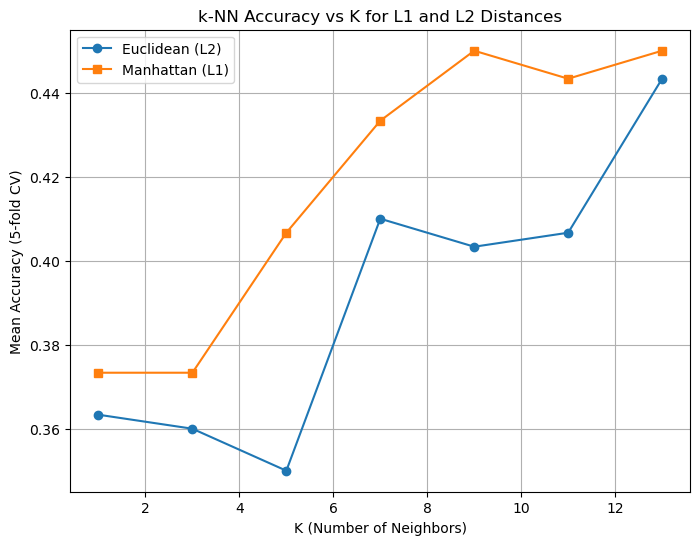

In [278]:
plt.figure(figsize=(8, 6))
plt.plot(K_VALUES, mean_accuracies_l2, marker="o", label="Euclidean (L2)")
plt.plot(K_VALUES, mean_accuracies_l1, marker="s", label="Manhattan (L1)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Mean Accuracy (5-fold CV)")
plt.title("k-NN Accuracy vs K for L1 and L2 Distances")
plt.grid(True)
plt.legend()
plt.show()


In [279]:
best_results = []
for metric_name, accs in [("L2", mean_accuracies_l2), ("L1", mean_accuracies_l1)]:
    for k, acc in zip(K_VALUES, accs):
        best_results.append((metric_name, k, acc))

best_metric, best_k, best_acc = max(best_results, key=lambda x: x[2])
print(f"Best overall: Metric={best_metric}, K={best_k}, Mean CV Accuracy={best_acc:.4f}")

best_metric_sklearn = "euclidean" if best_metric == "L2" else "manhattan"


Best overall: Metric=L1, K=9, Mean CV Accuracy=0.4500


In [280]:
knn_final = SimpleKNN(n_neighbors=best_k, metric=best_metric_sklearn)
knn_final.fit(X_train, y_train)

No test data found; showing top 5 predictions on training images (for demo).


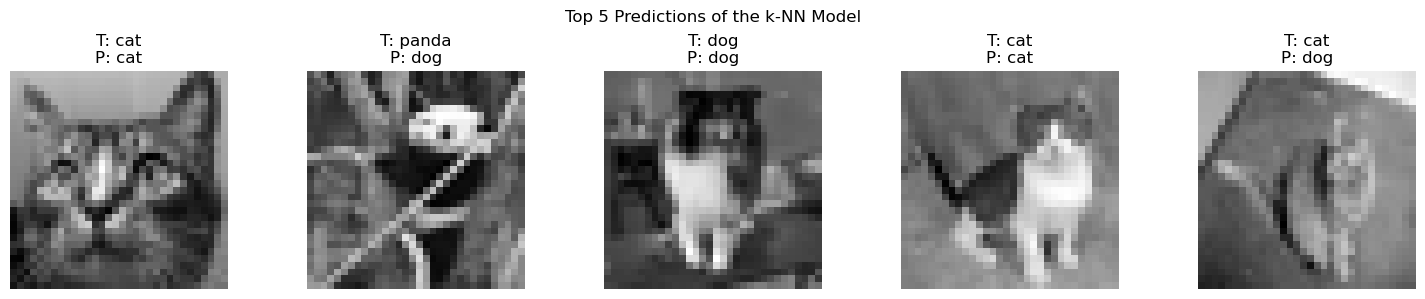

In [281]:
def show_top5_predictions(model, X_imgs, X_flat, y_true, class_names, n_samples=5):
    """
    Displays n_samples images with predicted and true labels.
    """
    n = len(X_imgs)
    indices = np.random.choice(n, size=min(n_samples, n), replace=False)

    plt.figure(figsize=(n_samples * 3, 3))
    for i, idx in enumerate(indices):
        img = X_imgs[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[model.predict([X_flat[idx]])[0]]

        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")

    plt.suptitle("Top 5 Predictions of the k-NN Model")
    plt.tight_layout()
    plt.show()
print("No test data found; showing top 5 predictions on training images (for demo).")
show_top5_predictions(knn_final, X_train_imgs, X_train, y_train, class_names, n_samples=5)





Splitting existing data...
New Training Shape: (240, 1024)
New Testing Shape:  (60, 1024)
Final Accuracy on Split Test Set: 0.4667


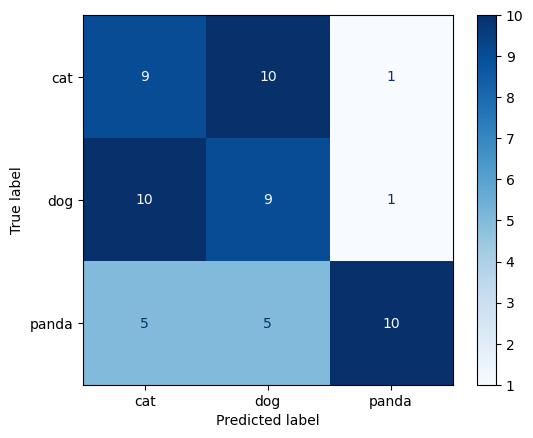

In [ ]:

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=43, 
    stratify=y_train
)

print(f"Splitting existing data...")
print(f"New Training Shape: {X_train_final.shape}")
print(f"New Testing Shape:  {X_test_final.shape}")
if best_metric == "L2":
    final_metric_name = "euclidean"
else:
    final_metric_name = "manhattan"
X_train_scaled = X_train_final / 255.0
X_test_scaled = X_test_final / 255.0 
# 3. Train on the 80%
final_model = SimpleKNN(n_neighbors=best_k, metric=final_metric_name)
final_model.fit(X_train_scaled, y_train_final)

# 4. Test on the 20%
y_pred = final_model.predict(X_test_scaled)
acc = accuracy_score(y_test_final, y_pred)

print(f"Final Accuracy on Split Test Set: {acc:.4f}")

# 5. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_final, 
    y_pred, 
    display_labels=class_names, 
    cmap=plt.cm.Blues
)
plt.show()

# Conclusion

In this experiment, we applied a k-NN classifier to 32×32 grayscale animal images and compared Euclidean (L2) and Manhattan (L1) distances using 5-fold cross-validation for different values of k. The images were converted to grayscale, resized.

The cross-validation results showed that the best performance was obtained with the Manhattan (L1) distance at k = 9, achieving a mean accuracy of 0.4500. This suggests that, for this grayscale pixel-based representation, summing absolute differences between pixels (L1) measures similarity more effectively than the squared differences used in L2.

Using this best setting (L1, k = 9), we trained a final model on 80% of the data and evaluated it on the remaining 20%, obtaining a test accuracy of 0.4667. The confusion matrix indicates that while the model can correctly classify many images, there is still noticeable confusion between certain animal classes, likely due to visual similarity and the limitations of using raw pixel values.

Overall, the results show that k-NN with the Manhattan distance can provide moderate performance on this dataset, but accuracy could likely be improved by using more informative features  or by applying dimensionality reduction before k-NN.